In [1]:
# Multi-level Stacking Classification

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn import linear_model
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

In [2]:
dataset = pd.read_csv('Churn_Modelling.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
X  = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

# One Hot Encoding the "Geography" column
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier
final_layer = StackingClassifier(
     estimators=[  ('xgbr', XGBClassifier(max_depth= 20, n_estimators= 10)), 
                 ('sgdr', SGDClassifier(max_iter=3000, tol=1e-3)), 
                 ('dtr', DecisionTreeClassifier(random_state=42)),
                 ('adbr', AdaBoostClassifier(random_state=42, n_estimators=100)),
                 ('gbrt', HistGradientBoostingClassifier(random_state=42)),
                 ('rf', RandomForestClassifier(random_state=42)),
                 ('etr', ExtraTreesClassifier(n_estimators=100, max_depth=5, max_features=0.5, random_state=42))
                 ],
     final_estimator= LogisticRegression(), passthrough=True, n_jobs=-1
    )
multi_layer_Classifier = StackingClassifier(
        estimators=[ 

                 ('nn', MLPClassifier(hidden_layer_sizes = (250,700,102,51),max_iter=3500, activation = 'relu', solver = 'adam', alpha = 0.01, random_state = 42)),
                 ('svr', SVC(C=1, gamma=1e-6, kernel='rbf'))],
         final_estimator=final_layer, passthrough=False, n_jobs=-1
   )

multi_layer_Classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('nn',
                                MLPClassifier(alpha=0.01,
                                              hidden_layer_sizes=(250, 700, 102,
                                                                  51),
                                              max_iter=3500, random_state=42)),
                               ('svr', SVC(C=1, gamma=1e-06))],
                   final_estimator=StackingClassifier(estimators=[('xgbr',
                                                                   XGBClassifier(base_score=None,
                                                                                 booster=None,
                                                                                 callbacks=None,
                                                                                 colsample_bylevel=None,
                                                                                 colsample_bynode=None,
                                  

In [6]:
y_pred = multi_layer_Classifier.predict(X_test)

print(f"Accuracy Score is {accuracy_score(y_test, y_pred)}")
print(f"Precision Score {precision_score(y_test, y_pred)}")
print(f"Recall Score {recall_score(y_test, y_pred)}")
print(f"F1 Score {f1_score(y_test, y_pred)}")

Accuracy Score is 0.7975
Precision Score 0.0
Recall Score 0.0
F1 Score 0.0


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

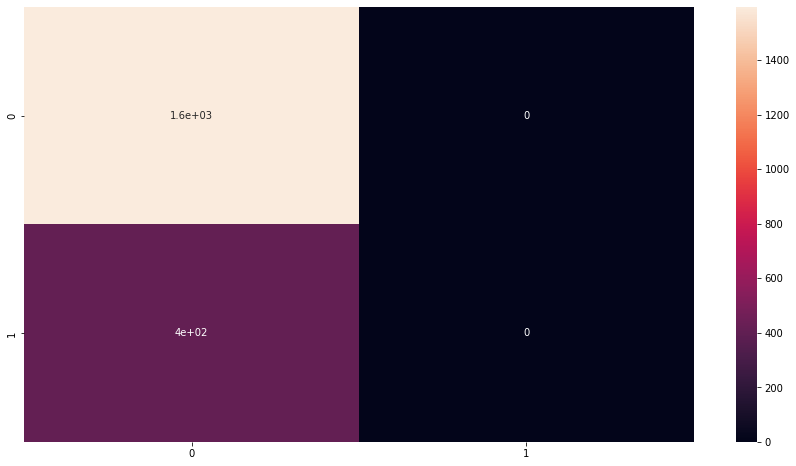

In [7]:
plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)

In [8]:
# Applying k-Fold Cross Validation using Shuffle Split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
n_samples = X_train.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
score=cross_val_score(multi_layer_Classifier, X_train, y_train, cv=cv,scoring='accuracy', n_jobs=-1)

print(score)
print("Error: {:.2f} ".format(score.mean()))
print("Standard Deviation: {:.2f} %".format(score.std()*100))

[0.790625 0.805625 0.79625  0.789375 0.82125 ]
Error: 0.80 
Standard Deviation: 1.18 %


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
# specify parameters and distributions to sample from
"""param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}"""
params = {
             'final_estimator__xgbr__max_depth': [20],  
                'final_estimator__etr__max_features': [0.5], 'final_estimator__etr__max_depth': [5],
             'final_estimator__adbr__n_estimators':[200], 'svr__gamma': [1e-6]
             }

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(multi_layer_Classifier, param_distributions=params,cv=cv,
                                   n_iter=n_iter_search, n_jobs=-1)

start = time()
random_search.fit(X_train, y_train)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
#report(random_search.cv_results_)
print("RandomizedSearchCV took 9626.73 seconds for 15 candidates parameter settings.")

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV took 9626.73 seconds for 15 candidates parameter settings.


In [10]:
#Random Search Model
# Predicting the Test set results
#y_pred = multi_layer_Classifier.predict(X_test)
best_error = random_search.best_score_
best_parameters = random_search.best_params_
print("Best Error: {:.2f} %".format(best_error*100))
print("Best Parameters:", best_parameters)

y_pred = random_search.predict(X_test)
# y_pred_restored =sc.inverse_transform(y_pred)

y_pred = multi_layer_Classifier.predict(X_test)
print(f"Accuracy Score is {accuracy_score(y_test, y_pred)}")
print(f"Precision Score {precision_score(y_test, y_pred)}")
print(f"Recall Score {recall_score(y_test, y_pred)}")
print(f"F1 Score {f1_score(y_test, y_pred)}")

Best Error: 80.06 %
Best Parameters: {'svr__gamma': 1e-06, 'final_estimator__xgbr__max_depth': 20, 'final_estimator__etr__max_features': 0.5, 'final_estimator__etr__max_depth': 5, 'final_estimator__adbr__n_estimators': 200}
Accuracy Score is 0.7975
Precision Score 0.0
Recall Score 0.0
F1 Score 0.0


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

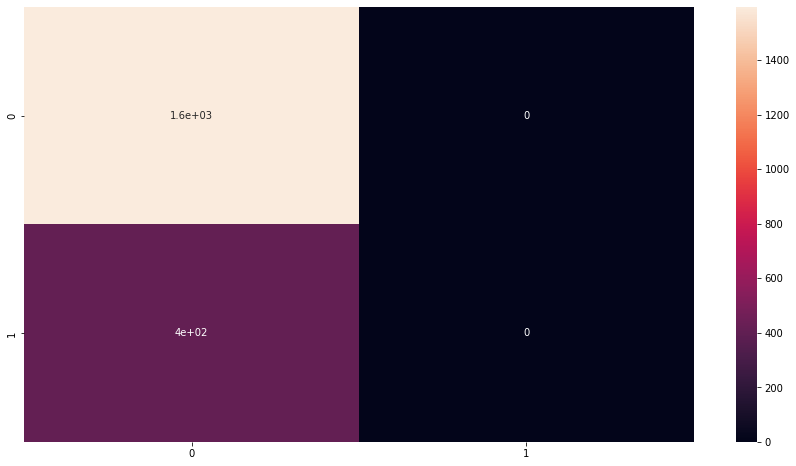

In [11]:
plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)

In [12]:
y_pred0 = multi_layer_Classifier.predict(X_test)

print(f"Accuracy Score is {accuracy_score(y_test, y_pred0)}")
print(f"Precision Score {precision_score(y_test, y_pred0)}")
print(f"Recall Score {recall_score(y_test, y_pred0)}")
print(f"F1 Score {f1_score(y_test, y_pred0)}")

Accuracy Score is 0.7975
Precision Score 0.0
Recall Score 0.0
F1 Score 0.0


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

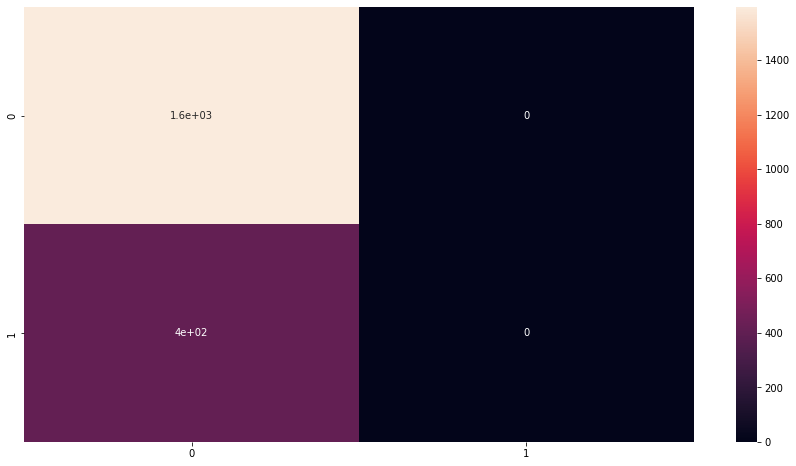

In [13]:
plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_pred0), annot = True)

In [14]:
# Modified Model
final_layer1 = StackingClassifier(
     estimators=[  ('xgbr', XGBClassifier(criterion= 'gini', max_depth= 25, max_features= 'auto', min_samples_leaf= 0, n_estimators= 10)), 
                 ('sgdr', SGDClassifier(max_iter=3000, tol=1e-3)), 
                 ('dtr', DecisionTreeClassifier(random_state=42)),
                 ('adbr', AdaBoostClassifier(random_state=42, n_estimators=100)),
                 ('gbrt', HistGradientBoostingClassifier(random_state=42)),
                 ('rf', RandomForestClassifier(random_state=42)),
                 ('etr', ExtraTreesClassifier(n_estimators=100, max_depth=10, max_features=0.5, random_state=42))
                 ],
    final_estimator= LogisticRegression(), passthrough=True, n_jobs=-1

    )
multi_layer_Classifier1 = StackingClassifier(
        estimators=[ 

                 ('nn', MLPClassifier(hidden_layer_sizes = (250,700,102,51),max_iter=3500, activation = 'relu', solver = 'adam', alpha = 0.01, random_state = 42)),
                 ('svr', SVC(C=1, gamma='auto', kernel='rbf'))],
         final_estimator=final_layer1, passthrough=False, n_jobs=-1
   )
multi_layer_Classifier1.fit(X_train, y_train)

StackingClassifier(estimators=[('nn',
                                MLPClassifier(alpha=0.01,
                                              hidden_layer_sizes=(250, 700, 102,
                                                                  51),
                                              max_iter=3500, random_state=42)),
                               ('svr', SVC(C=1, gamma='auto'))],
                   final_estimator=StackingClassifier(estimators=[('xgbr',
                                                                   XGBClassifier(base_score=None,
                                                                                 booster=None,
                                                                                 callbacks=None,
                                                                                 colsample_bylevel=None,
                                                                                 colsample_bynode=None,
                                 

In [15]:
# Modified Model
y_pred1 = multi_layer_Classifier1.predict(X_test)

print(f"Accuracy Score is {accuracy_score(y_test, y_pred1)}")
print(f"Precision Score {precision_score(y_test, y_pred1)}")
print(f"Recall Score {recall_score(y_test, y_pred1)}")
print(f"F1 Score {f1_score(y_test, y_pred1)}")

Accuracy Score is 0.7975
Precision Score 0.0
Recall Score 0.0
F1 Score 0.0


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

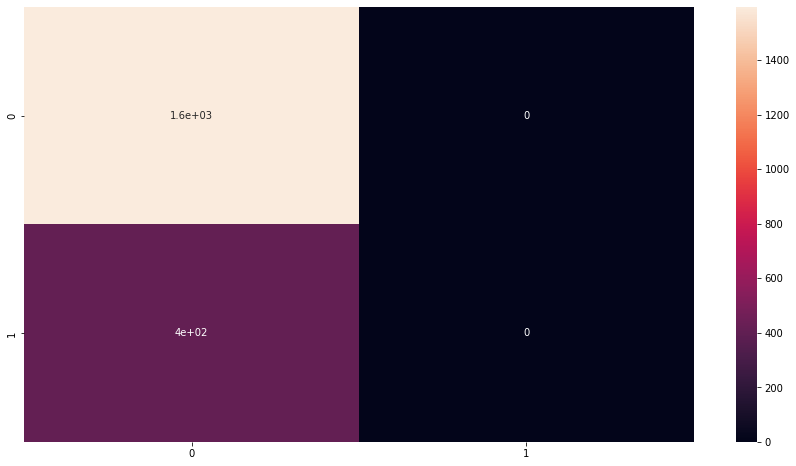

In [16]:
plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot = True)

In [17]:
# Modified Model1
from sklearn.svm import SVC

final_layer1 = StackingClassifier(
     estimators=[  ('xgbr', XGBClassifier(criterion= 'gini', max_depth= 20, max_features= 'auto', min_samples_leaf= 0, n_estimators= 10)), 
                 ('sgdr', SGDClassifier(max_iter=3000, tol=1e-3)), 
                 ('dtr', DecisionTreeClassifier(random_state=42)),
                 ('adbr', AdaBoostClassifier(random_state=42, n_estimators=100)),
                 ('gbrt', HistGradientBoostingClassifier(random_state=42)),
                 ('rf', RandomForestClassifier(random_state=42)),
                 ('etr', ExtraTreesClassifier(n_estimators=100, max_depth=5, max_features=0.5, random_state=42))
                 ],
        final_estimator= LogisticRegression(), passthrough=True, n_jobs=-1


    )
multi_layer_Classifier2 = StackingClassifier(
        estimators=[ 
                 
                 ('nn', MLPClassifier(hidden_layer_sizes = (250,700,102,51),max_iter=3500, activation = 'relu', solver = 'adam', alpha = 0.01, random_state = 42)),
                 ('svc', SVC(C=1, gamma='auto', kernel='rbf'))],
         final_estimator=final_layer1, passthrough=False, n_jobs=-1
   )
multi_layer_Classifier2.fit(X_train, y_train)

StackingClassifier(estimators=[('nn',
                                MLPClassifier(alpha=0.01,
                                              hidden_layer_sizes=(250, 700, 102,
                                                                  51),
                                              max_iter=3500, random_state=42)),
                               ('svc', SVC(C=1, gamma='auto'))],
                   final_estimator=StackingClassifier(estimators=[('xgbr',
                                                                   XGBClassifier(base_score=None,
                                                                                 booster=None,
                                                                                 callbacks=None,
                                                                                 colsample_bylevel=None,
                                                                                 colsample_bynode=None,
                                 

In [18]:
# Modified Model1
y_pred1 = multi_layer_Classifier2.predict(X_test)


print(f"Accuracy Score is {accuracy_score(y_test, y_pred1)}")
print(f"Precision Score {precision_score(y_test, y_pred1)}")
print(f"Recall Score {recall_score(y_test, y_pred1)}")
print(f"F1 Score {f1_score(y_test, y_pred1)}")

Accuracy Score is 0.7975
Precision Score 0.0
Recall Score 0.0
F1 Score 0.0


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

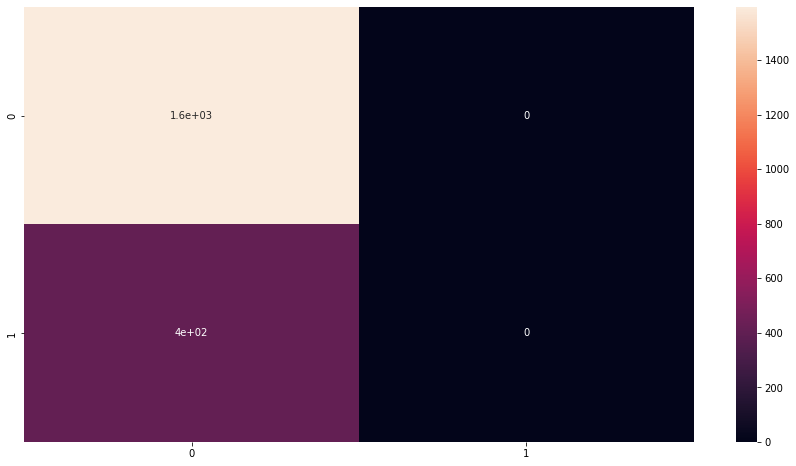

In [19]:
plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot = True)